In [1]:
import anndata as ad
import os
from SpatialQuery.spatial_query import spatial_query
from SpatialQuery.spatial_query_multiple_fov import spatial_query_multi
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
pd.set_option('display.max_colwidth', 1000)

In [2]:
from os.path import join

In [3]:
data_path = "./data/HBM987_KWLK_254/"

# adata_expr = ad.read_h5ad(os.path.join(data_path, 'expr.h5ad'))
adata = ad.read_h5ad(join("data", "HBM987_KWLK_254", "secondary_analysis.h5ad"))
fig_size = (8, 4)

In [4]:
adata

AnnData object with n_obs × n_vars = 4058 × 26265
    obs: 'n_genes', 'n_counts', 'leiden', 'umap_density', 'predicted.ASCT.celltype', 'predicted.ASCT.celltype.score'
    var: 'hugo_symbol', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'annotation_metadata', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'umap_density_params'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'X_umap_proj'
    varm: 'PCs'
    layers: 'spliced', 'spliced_unspliced_sum', 'unscaled', 'unspliced'
    obsp: 'connectivities', 'distances'

In [5]:
spatial_key = 'X_spatial'
label_key = 'predicted.ASCT.celltype'

In [6]:
# Test building kd tree
tt = spatial_query(adata=adata, dataset = 'test', spatial_key=spatial_key, label_key=label_key, leaf_size=10)

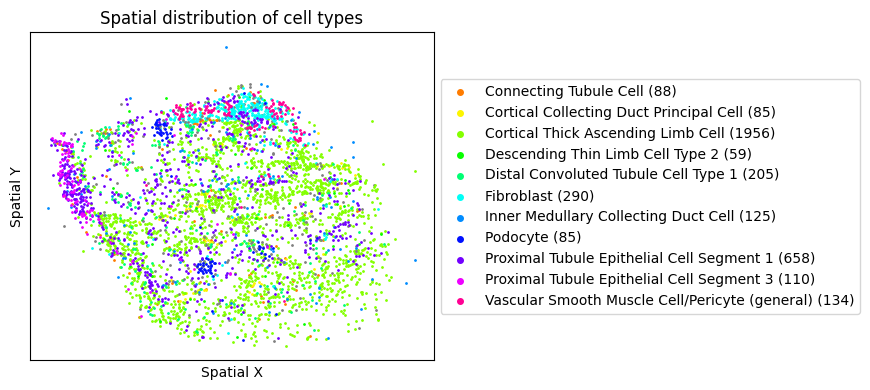

In [7]:
# tt.plot_fov(fig_size=fig_size)
tt.plot_fov(fig_size=fig_size)

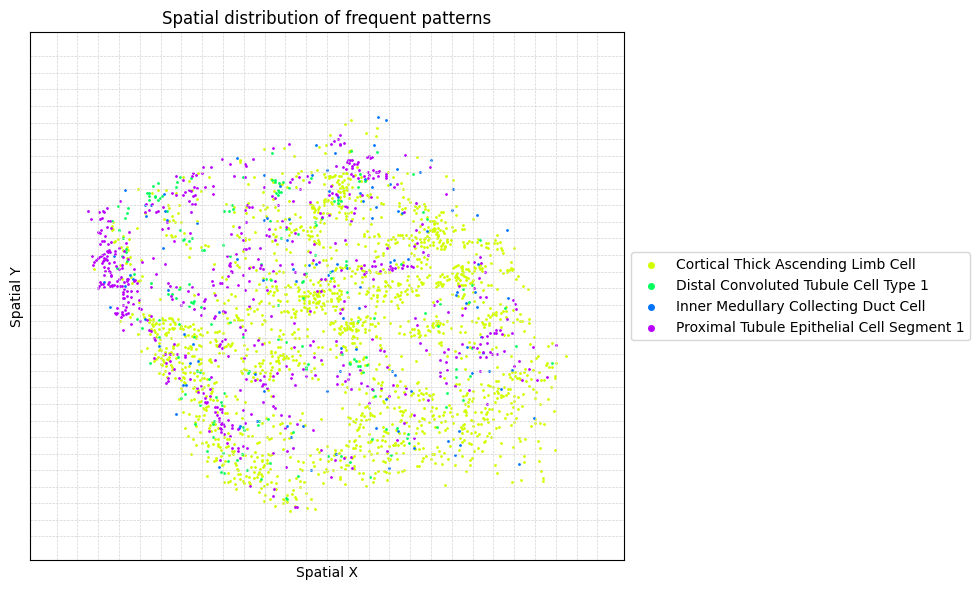

In [8]:
# Test frequent patterns of fov
max_dist = 150
min_size = 4
min_count = 10
min_support = 0.5
dis_duplicates=False # if distinguish duplicates of cell types in neighborhood


fp_tree, grid_pos = tt.find_patterns_grid(max_dist=max_dist,
                               min_size=min_size,
                               min_count=min_count,
                               min_support=min_support, 
                               dis_duplicates=dis_duplicates,
                               if_display=True,
                               fig_size = (9, 6),
                               return_cellID=True,
                               return_grid=True
                              ) 

In [9]:
fp_tree

,support,itemsets,cell_id
0,0.519540,"[Cortical Thick Ascending Limb Cell, Distal Convoluted Tubule Cell Type 1, Proximal Tubule Epithelial Cell Segment 1]","{0, 2, 5, 6, 9, 16, 20, 21, 22, 23, 24, 27, 28, 32, 36, 37, 38, 44, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 71, 73, 76, 77, 80, 82, 83, 85, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 104, 105, 106, 109, 110, 111, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 138, 142, 144, 146, 147, 148, 150, 158, 159, 160, 161, 162, 163, 164, 165, 169, 170, ...}"
1,0.508046,"[Cortical Thick Ascending Limb Cell, Inner Medullary Collecting Duct Cell]","{0, 2, 5, 6, 9, 11, 21, 22, 24, 28, 35, 36, 37, 38, 43, 45, 48, 51, 52, 53, 54, 55, 57, 58, 60, 62, 64, 67, 73, 74, 75, 76, 77, 82, 83, 84, 88, 89, 92, 96, 97, 99, 100, 103, 109, 111, 114, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 134, 136, 138, 140, 144, 145, 146, 148, 156, 160, 162, 163, 169, 170, 176, 177, 180, 182, 183, 191, 193, 194, 196, 202, 205, 206, 211, 212, 217, 222, 223, 224, 228, 229, 230, 234, 235, 242, 246, ...}"


In [10]:
tab20_rgb = [ [int(r*255),int(g*255),int(b*255)] for (r, g, b, a) in [plt.cm.tab20(i) for i in range(20)]]

In [11]:
additional_obs_sets = {
    "version": "0.1.3",
    "tree": [
        {
            "name": "Spatial-Query Results",
            "children": [
                
            ]
        }
    ]
}

obs_set_color = [
    {
        "color": [255, 255, 255],
        "path": ["Cell Type"],
    },
    {
        "color": [255, 255, 255],
        "path": ["Spatial-Query Results"],
    }
]

ct_to_color = dict()

for ct_i, cell_type in enumerate(adata.obs[label_key].unique().tolist()):
    color = tab20_rgb[ct_i % 20]
    ct_to_color[cell_type] = color
    path = ["Cell Type", cell_type]
    obs_set_color.append({
        "color": color,
        "path": path
    })

cell_i_to_cell_id = dict(zip(range(adata.obs.shape[0]), adata.obs.index.tolist()))
cell_id_to_cell_type = dict(zip(adata.obs.index.tolist(), adata.obs[label_key].tolist()))

def get_matching_cell_ids(cell_type, cell_i):
    cell_ids = [ cell_i_to_cell_id[i] for i in cell_i ]
    matches = []
    for cell_id in cell_ids:
        cell_ct = cell_id_to_cell_type[cell_id]
        if cell_ct == cell_type:
            matches.append([cell_id, None])
    return matches

In [12]:
def fp_tree_to_obs_sets_tree(fp_tree, sq_id):
    additional_obs_sets = {
        "version": "0.1.3",
        "tree": [
            {
                "name": f"Spatial-Query Results {sq_id}",
                "children": [
                    
                ]
            }
        ]
    }

    obs_set_color = []
    
    for row_i, row in fp_tree.iterrows():
        motif = row["itemsets"]
        cell_i = row["cell_id"]
    
        motif_name = str(list(motif))
    
        additional_obs_sets["tree"][0]["children"].append({
            "name": motif_name,
            "children": [
                {
                    "name": cell_type,
                    "set": get_matching_cell_ids(cell_type, cell_i)
                }
                for cell_type in motif
            ]
        })
    
        obs_set_color.append({
            "color": [255, 255, 255],
            "path": [additional_obs_sets["tree"][0]["name"], motif_name]
        })
    
        for cell_type in motif:
            color = ct_to_color[cell_type]
            path = [additional_obs_sets["tree"][0]["name"], motif_name, cell_type]
            obs_set_color.append({
                "color": color,
                "path": path
            })
    return (additional_obs_sets, obs_set_color)
            

In [13]:
def run_sq(prev_config):
    query_params = prev_config["coordinationSpace"]["queryParams"]["A"]

    max_dist = query_params.get("maxDist", 150)
    min_size = query_params.get("minSize", 4)
    min_count = query_params.get("minCount", 10)
    min_support = query_params.get("minSupport", 0.5)
    dis_duplicates = query_params.get("disDuplicates", False) # if distinguish duplicates of cell types in neighborhood
    query_type = query_params.get("queryType", "grid")

    query_uuid = query_params["uuid"]

    params_dict = dict(
        max_dist=max_dist,
        min_size=min_size,
        min_count=min_count,
        min_support=min_support, 
        dis_duplicates=dis_duplicates,
        if_display=True,
        fig_size = (9, 6),
        return_cellID=True,
    )
    print(params_dict)

    if query_type == "rand":
        # TODO: implement param similar to return_grid for find_patterns_rand (to return the random points used)
        fp_tree = tt.find_patterns_rand(**params_dict)
    elif query_type == "grid":
        params_dict["return_grid"] = True
        fp_tree, grid_pos = tt.find_patterns_grid(**params_dict)
    # TODO: support query_type == "ct-center"
    
    # Previous values
    additional_obs_sets = prev_config["coordinationSpace"]["additionalObsSets"]["A"]
    obs_set_color = prev_config["coordinationSpace"]["obsSetColor"]["A"]

    # Perform query 
    (new_additional_obs_sets, new_obs_set_color) = fp_tree_to_obs_sets_tree(fp_tree, query_uuid)
    
    additional_obs_sets["tree"][0] = new_additional_obs_sets["tree"][0]
    prev_config["coordinationSpace"]["additionalObsSets"]["A"] = additional_obs_sets

    obs_set_color += new_obs_set_color
    prev_config["coordinationSpace"]["obsSetColor"]["A"] = obs_set_color

    motif_to_select = new_additional_obs_sets["tree"][0]["children"][0]["name"]
    new_obs_set_selection = [ [new_additional_obs_sets["tree"][0]["name"], motif_to_select, node["name"]] for node in new_additional_obs_sets["tree"][0]["children"][0]["children"] ]
    prev_config["coordinationSpace"]["obsSetSelection"]["A"] = new_obs_set_selection

    # TODO: set obsSetExpansion

    return { **prev_config, "uid": f"with_query_{query_uuid}" }

In [14]:
from vitessce import (
    VitessceConfig,
    AnnDataWrapper,
    CsvWrapper,
    ViewType as vt,
    CoordinationType as ct,
    CoordinationLevel as CL,
)

In [15]:
zarr_path = join("data", "HBM987_KWLK_254", "secondary_analysis.h5ad.zarr")
adata.write_zarr(zarr_path)

/Users/mkeller/software/miniconda3/envs/spatial-query/lib/python3.11/site-packages/zarr/creation.py:295: UserWarning: ignoring keyword argument 'maxshape'
  warn("ignoring keyword argument %r" % k)


In [16]:
grid_pos.shape

(810, 2)

In [17]:
grid_df = pd.DataFrame(data=[], index=[], columns=["X", "Y"])
grid_df["X"] = grid_pos[:, 0]
grid_df["Y"] = grid_pos[:, 1]
grid_df.index = grid_df.index.rename("grid_index")

In [18]:
csv_path = join("data", "grid_pos.csv")
grid_df.to_csv(csv_path, index=True)

In [19]:
vc = VitessceConfig(schema_version="1.0.16", name="Spatial-Query")
dataset = vc.add_dataset("Query results").add_object(AnnDataWrapper(
    adata_path=zarr_path,
    obs_feature_matrix_path="X",
    obs_set_paths=["obs/predicted.ASCT.celltype"],
    obs_set_names=["Cell Type"],
    obs_spots_path="obsm/X_spatial",
    feature_labels_path="var/hugo_symbol",
    coordination_values={
        "featureLabelsType": "Gene symbol",
    }
)).add_object(CsvWrapper(
    csv_path=csv_path,
    data_type="obsSpots",
    options={
        "obsIndex": "grid_index",
        "obsSpots": ["X", "Y"],
    },
    coordination_values={
        "obsType": "gridPosition"
    }
))

spatial_view = vc.add_view("spatialBeta", dataset=dataset)
lc_view = vc.add_view("layerControllerBeta", dataset=dataset)
sets_view = vc.add_view("obsSets", dataset=dataset)
features_view = vc.add_view("featureList", dataset=dataset)
sq_view = vc.add_view("spatialQuery", dataset=dataset)

obs_set_selection_scope, = vc.add_coordination("obsSetSelection",)
obs_set_selection_scope.set_value(None)

sets_view.use_coordination(obs_set_selection_scope)
sq_view.use_coordination(obs_set_selection_scope)
spatial_view.use_coordination(obs_set_selection_scope)
features_view.use_coordination(obs_set_selection_scope)

vc.link_views([spatial_view, lc_view, sets_view, features_view], ["additionalObsSets", "obsSetColor"], [additional_obs_sets, obs_set_color])
vc.link_views_by_dict([spatial_view, lc_view], {
    "spotLayer": CL([
        {
            "obsType": "gridPosition",
            "spatialSpotRadius": 150/2,
            "spatialSpotFilled": False,
            "spatialSpotStrokeWidth": 2,
            "additionalObsSets": None,
            "obsSetColor": None,
            "obsSetSelection": obs_set_selection_scope,
            "featureSelection": None,
            "obsColorEncoding": "spatialLayerColor",
            "spatialLayerColor": [255, 255, 255],
            "spatialLayerVisible": True,
            "spatialLayerOpacity": 0.5,
            "legendVisible": False,
        },
        {
            "obsType": "cell",
            "spatialSpotRadius": 15,
        },
    ])
})

#vc.set_coordination_value("obsType", "init_A_obsSpots_1", "cell")
#vc.set_coordination_value("spatialSpotRadius", "init_A_obsSpots_1", 15)

vc.layout((spatial_view | (lc_view / features_view)) / (sets_view | sq_view));

In [32]:
from esbuild_py import transform

In [44]:
PLUGIN_ESM = transform(Path("./create-plugins.js").read_text(encoding="utf-8"))

In [45]:
vw = vc.widget(height=900, plugin_esm=PLUGIN_ESM, remount_on_uid_change=False)

def handle_change(change):
    new_config = change.new
    query_params = new_config["coordinationSpace"]["queryParams"]["A"]
    if query_params and "uuid" in query_params:
        print(query_params)
        query_uuid = query_params.get("uuid", None)
        if new_config["uid"] != f"with_query_{query_uuid}":
            vw.config = run_sq(new_config)

vw.observe(handle_change, names=["config"])

/Users/mkeller/software/miniconda3/envs/spatial-query/lib/python3.11/site-packages/traitlets/traitlets.py:842: DeprecationWarning: Deprecated in traitlets 4.1, use the instance .metadata dictionary directly, like x.metadata[key] or x.metadata.get(key, default)
  warn("Deprecated in traitlets 4.1, " + msg, DeprecationWarning, stacklevel=2)
/Users/mkeller/software/miniconda3/envs/spatial-query/lib/python3.11/site-packages/traitlets/traitlets.py:842: DeprecationWarning: Deprecated in traitlets 4.1, use the instance .metadata dictionary directly, like x.metadata[key] or x.metadata.get(key, default)
  warn("Deprecated in traitlets 4.1, " + msg, DeprecationWarning, stacklevel=2)


In [46]:
vw

VitessceWidget(config={'version': '1.0.16', 'name': 'Spatial-Query', 'description': '', 'datasets': [{'uid': '…

In [149]:
vc2 = VitessceConfig(schema_version="1.0.16", name="Spatial-Query")
dataset = vc2.add_dataset("Query results").add_object(AnnDataWrapper(
    adata_path=zarr_path,
    obs_feature_matrix_path="X",
    obs_set_paths=["obs/predicted.ASCT.celltype"],
    obs_set_names=["Cell Type"],
    obs_spots_path="obsm/X_spatial",
    obs_labels_path="obs/predicted.ASCT.celltype",
    feature_labels_path="var/hugo_symbol",
    coordination_values={
        "obsLabelsType": "Cell Type",
        "featureLabelsType": "Gene symbol",
    }
))

spatial_view_1 = vc2.add_view("spatialBeta", dataset=dataset)
spatial_view_2 = vc2.add_view("spatialBeta", dataset=dataset)
sets_view_1 = vc2.add_view("obsSets", dataset=dataset)
sets_view_2 = vc2.add_view("obsSets", dataset=dataset)

vc2.link_views([spatial_view_1, spatial_view_2, sets_view_1, sets_view_2], ["additionalObsSets", "obsSetColor"], [additional_obs_sets, obs_set_color])
vc2.link_views([spatial_view_1, spatial_view_2], ["spatialZoom", "spatialTargetX", "spatialTargetY"], [None, None, None])
vc2.link_views([spatial_view_1, sets_view_1], ["obsSetSelection", "obsSetExpansion"], [None, None])
vc2.link_views([spatial_view_2, sets_view_2], ["obsSetSelection", "obsSetExpansion"], [None, None])


vc2.set_coordination_value("obsType", "init_A_obsSpots_0", "cell")
vc2.set_coordination_value("spatialSpotRadius", "init_A_obsSpots_0", 15)

vc2.layout((spatial_view_1 | spatial_view_2) / (sets_view_1 | sets_view_2));

In [ ]:
vc2.widget(height=1200)